In [45]:
!pip install torch torchvision transformers pillow faiss-cpu google-generativeai requests

  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl (363.4 MB)


In [46]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import faiss
import google.generativeai as genai
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import json
import re
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Configuration
DATASET_PATH = "/kaggle/input/clothes-tryon-dataset/clothes_tryon_dataset"
CATALOG_PATH = os.path.join(DATASET_PATH, "train/cloth")
USER_IMAGES_PATH = os.path.join(DATASET_PATH, "train/image")
PAIRS_FILE = os.path.join(DATASET_PATH, "train_pairs.txt")

# Gemini API Configuration
GEMINI_API_KEY = "REDACTED"  # Replace with your actual key
genai.configure(api_key=GEMINI_API_KEY)

# Model Configuration
EMBEDDING_DIM = 512
TOP_K = 5
BATCH_SIZE = 32

print(f"Dataset path: {DATASET_PATH}")
print(f"Catalog path: {CATALOG_PATH}")
print(f"User images path: {USER_IMAGES_PATH}")
print(f"Pairs file: {PAIRS_FILE}")

Dataset path: /kaggle/input/clothes-tryon-dataset/clothes_tryon_dataset
Catalog path: /kaggle/input/clothes-tryon-dataset/clothes_tryon_dataset/train/cloth
User images path: /kaggle/input/clothes-tryon-dataset/clothes_tryon_dataset/train/image
Pairs file: /kaggle/input/clothes-tryon-dataset/clothes_tryon_dataset/train_pairs.txt


In [99]:
from transformers import CLIPProcessor, CLIPModel

# Load CLIP model and processor
model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_name).to(device)
clip_processor = CLIPProcessor.from_pretrained(model_name)

print(f"Loaded CLIP model: {model_name}")
print(f"Model device: {next(clip_model.parameters()).device}")

Loaded CLIP model: openai/clip-vit-base-patch32
Model device: cuda:0


In [100]:
def load_and_preprocess_image(image_path: str, target_size: Tuple[int, int] = (224, 224)) -> torch.Tensor:
    """Load and preprocess image for CLIP model"""
    try:
        image = Image.open(image_path).convert('RGB')
        image = image.resize(target_size)
        
        # Use CLIP processor for consistent preprocessing
        inputs = clip_processor(images=image, return_tensors="pt")
        return inputs['pixel_values'].to(device)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def extract_embedding(image_tensor: torch.Tensor) -> np.ndarray:
    """Extract embedding from image tensor using CLIP"""
    with torch.no_grad():
        image_features = clip_model.get_image_features(image_tensor)
        # Normalize embeddings
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features.cpu().numpy()

def display_image_with_info(image_path: str, title: str = "", similarity_score: float = None):
    """Display image with title and optional similarity score"""
    try:
        image = Image.open(image_path)
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.axis('off')
        
        if similarity_score is not None:
            title += f" (Score: {similarity_score:.3f})"
        
        plt.title(title, fontsize=12, pad=20)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error displaying image {image_path}: {e}")

In [50]:
def build_catalog_index():
    """Build FAISS index from catalog images with debugging"""
    print("Building catalog index...")
    
    # Get all catalog images
    catalog_files = [f for f in os.listdir(CATALOG_PATH) if f.endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Found {len(catalog_files)} catalog images")
    
    if len(catalog_files) == 0:
        print(f"❌ No catalog images found in {CATALOG_PATH}")
        print(f"Available files in catalog directory:")
        try:
            all_files = os.listdir(CATALOG_PATH)
            for f in all_files[:10]:
                print(f"  - {f}")
            if len(all_files) > 10:
                print(f"  ... and {len(all_files) - 10} more")
        except Exception as e:
            print(f"Error listing directory: {e}")
        return None, []
    
    # Initialize FAISS index
    index = faiss.IndexFlatIP(EMBEDDING_DIM)  # Inner product for cosine similarity
    
    catalog_embeddings = []
    valid_files = []
    
    for i, filename in enumerate(catalog_files):
        if i % 50 == 0:
            print(f"Processing {i}/{len(catalog_files)} images...")
        
        image_path = os.path.join(CATALOG_PATH, filename)
        
        # Debug: Check if file exists
        if not os.path.exists(image_path):
            print(f"⚠️ File not found: {image_path}")
            continue
            
        image_tensor = load_and_preprocess_image(image_path)
        
        if image_tensor is not None:
            embedding = extract_embedding(image_tensor)
            catalog_embeddings.append(embedding)
            valid_files.append(filename)
        else:
            print(f"⚠️ Failed to process: {filename}")
    
    if catalog_embeddings:
        # Stack embeddings and add to index
        catalog_embeddings = np.vstack(catalog_embeddings)
        index.add(catalog_embeddings)
        
        print(f"✅ Built index with {len(valid_files)} catalog items")
        print(f"Index size: {index.ntotal}")
        
        # Test the index
        test_embedding = np.random.randn(1, EMBEDDING_DIM).astype('float32')
        test_embedding = test_embedding / np.linalg.norm(test_embedding)
        similarities, indices = index.search(test_embedding, 1)
        print(f"✅ Index test successful - found {len(indices[0])} results")
        
        return index, valid_files
    else:
        print("❌ No valid catalog embeddings found!")
        return None, []

# Build the catalog index
catalog_index, catalog_files = build_catalog_index()

Building catalog index...
Found 11647 catalog images
Processing 0/11647 images...
Processing 50/11647 images...
Processing 100/11647 images...
Processing 150/11647 images...
Processing 200/11647 images...
Processing 250/11647 images...
Processing 300/11647 images...
Processing 350/11647 images...
Processing 400/11647 images...
Processing 450/11647 images...
Processing 500/11647 images...
Processing 550/11647 images...
Processing 600/11647 images...
Processing 650/11647 images...
Processing 700/11647 images...
Processing 750/11647 images...
Processing 800/11647 images...
Processing 850/11647 images...
Processing 900/11647 images...
Processing 950/11647 images...
Processing 1000/11647 images...
Processing 1050/11647 images...
Processing 1100/11647 images...
Processing 1150/11647 images...
Processing 1200/11647 images...
Processing 1250/11647 images...
Processing 1300/11647 images...
Processing 1350/11647 images...
Processing 1400/11647 images...
Processing 1450/11647 images...
Processing

In [61]:
def analyze_user_intent_and_guide_search(user_image_path: str, user_prompt: str) -> dict:
    """
    LLM analyzes user intent, extracts attributes, and generates CLIP search terms.
    """
    from PIL import Image
    import re, json
    import google.generativeai as genai

    user_image = Image.open(user_image_path)
    model = genai.GenerativeModel('gemini-2.0-flash-exp')

    prompt = f"""
    You are an AI fashion stylist. Analyze the user's image and request to determine the best search strategy.

    USER REQUEST: "{user_prompt}"

    In addition to previous fields, extract:
    - "detected_gender": "male|female|unisex|other|unknown"
    - "skin_tone": "fair|medium|dark|olive|other|unknown"
    - "body_type": "slim|average|plus-size|athletic|petite|tall|other|unknown"
    - "age_group": "child|teen|adult|senior|unknown"
    - "season": "summer|winter|spring|autumn|all-season|unknown"
    - "occasion": "casual|formal|business|party|wedding|sports|vacation|other|unknown"
    - "color_palette": ["red", "blue", ...]  # main colors detected
    - "fashion_era": "modern|retro|vintage|y2k|other|unknown"
    - "detected_patterns": ["stripes", "floral", ...]  # if visible
    - "detected_materials": ["denim", "cotton", ...]  # if visible
    - "detected_brands": ["Nike", "Adidas", ...]  # if visible

    Also, generate 3-5 CLIP search terms that combine these attributes, e.g.:
    ["red floral dress for plus-size women", "Nike logo t-shirt for teens", "outfit for dark skin tone in summer"]

    Respond in this JSON:
    {{
        "search_strategy": "...",
        "clip_search_terms": [...],
        "user_intent": "...",
        "style_analysis": "...",
        "confidence": "...",
        "detected_gender": "...",
        "skin_tone": "...",
        "body_type": "...",
        "age_group": "...",
        "season": "...",
        "occasion": "...",
        "color_palette": [...],
        "fashion_era": "...",
        "detected_patterns": [...],
        "detected_materials": [...],
        "detected_brands": [...]
    }}
    """

    try:
        response = model.generate_content([prompt, user_image])
        json_match = re.search(r'\{.*\}', response.text, re.DOTALL)
        if json_match:
            result = json.loads(json_match.group())
            print(f"🤖 LLM Strategy: {result.get('search_strategy')}")
            print(f"🔎 CLIP Search Terms: {result.get('clip_search_terms')}")
            return result
        else:
            return {
                "search_strategy": "similar",
                "clip_search_terms": ["clothing"],
                "user_intent": "casual",
                "style_analysis": "Basic style analysis",
                "confidence": "low"
            }
    except Exception as e:
        print(f"Error calling Gemini API: {e}")
        return {
            "search_strategy": "similar",
            "clip_search_terms": ["clothing"],
            "user_intent": "casual",
            "style_analysis": "API error",
            "confidence": "low"
        }

In [52]:
def search_by_text_query(search_term, top_k):
    text_inputs = clip_processor(text=search_term, return_tensors="pt").to(device)
    with torch.no_grad():
        text_features = clip_model.get_text_features(**text_inputs)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    similarities, indices = catalog_index.search(text_features.cpu().numpy(), top_k)
    results = []
    for i, (score, idx) in enumerate(zip(similarities[0], indices[0])):
        if idx < len(catalog_files):
            filename = catalog_files[idx]
            image_path = os.path.join(CATALOG_PATH, filename)
            results.append({
                'image_path': image_path,
                'filename': filename,
                'similarity_score': float(score),
                'search_type': 'text',
                'search_term': search_term,
                'rank': i + 1
            })
    return results
    
def search_with_llm_guidance(user_image_path: str, user_prompt: str, top_k: int = TOP_K):
    """
    Use LLM to guide CLIP search strategy, combining image and text-based retrieval.
    """
    print("🎯 LLM-Guided CLIP Search...")

    # Step 1: LLM analyzes intent and provides search strategy and attributes
    llm_analysis = analyze_user_intent_and_guide_search(user_image_path, user_prompt)

    # Step 2: Handle different search strategies
    if llm_analysis["search_strategy"] == "evaluation_only":
        print("📝 User wants evaluation only - no catalog search needed")
        return [], llm_analysis

    # Step 3: Retrieve using both image and LLM-generated text queries
    recommendations = []

    # Image-based retrieval
    user_image_tensor = load_and_preprocess_image(user_image_path)
    if user_image_tensor is not None:
        user_embedding = extract_embedding(user_image_tensor)
        similarities, indices = catalog_index.search(user_embedding.reshape(1, -1), top_k)
        for i, (score, idx) in enumerate(zip(similarities[0], indices[0])):
            if idx < len(catalog_files):
                filename = catalog_files[idx]
                image_path = os.path.join(CATALOG_PATH, filename)
                recommendations.append({
                    'image_path': image_path,
                    'filename': filename,
                    'similarity_score': float(score),
                    'search_type': 'image',
                    'rank': i + 1
                })

    # Text-based retrieval (LLM-guided)
    for term in llm_analysis.get("clip_search_terms", []):
        text_results = search_by_text_query(term, top_k)
        recommendations.extend(text_results)

    # Deduplicate by filename, keep highest score
    unique = {}
    for rec in recommendations:
        fname = rec['filename']
        if fname not in unique or rec['similarity_score'] > unique[fname]['similarity_score']:
            unique[fname] = rec
    deduped = list(unique.values())

    # Sort by similarity score
    deduped.sort(key=lambda x: x['similarity_score'], reverse=True)
    # Re-rank
    for i, rec in enumerate(deduped):
        rec['rank'] = i + 1

    return deduped[:top_k], llm_analysis

def search_similar_items(user_image_path: str, top_k: int):
    """Search for items similar to what user is wearing"""
    
    user_image_tensor = load_and_preprocess_image(user_image_path)
    if user_image_tensor is None:
        return []
    
    user_embedding = extract_embedding(user_image_tensor)
    
    # Direct visual similarity search
    similarities, indices = catalog_index.search(user_embedding.reshape(1, -1), top_k)
    
    recommendations = []
    for i, (score, idx) in enumerate(zip(similarities[0], indices[0])):
        if idx < len(catalog_files):
            filename = catalog_files[idx]
            image_path = os.path.join(CATALOG_PATH, filename)
            
            recommendations.append({
                'image_path': image_path,
                'filename': filename,
                'similarity_score': float(score),
                'search_type': 'similar',
                'rank': i + 1
            })
    
    return recommendations

def search_complementary_items(user_image_path: str, search_terms: List[str], top_k: int):
    """Search for complementary items using LLM-suggested terms"""
    
    print(f"🔍 Searching for: {search_terms}")
    
    all_recommendations = []
    
    for term in search_terms:
        # Create text embedding for the search term
        text_inputs = clip_processor(text=term, return_tensors="pt", padding=True, truncation=True).to(device)
        
        with torch.no_grad():
            text_features = clip_model.get_text_features(**text_inputs)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        # Search catalog with text embedding
        similarities, indices = catalog_index.search(text_features.cpu().numpy(), top_k)
        
        for i, (score, idx) in enumerate(zip(similarities[0], indices[0])):
            if idx < len(catalog_files):
                filename = catalog_files[idx]
                image_path = os.path.join(CATALOG_PATH, filename)
                
                all_recommendations.append({
                    'image_path': image_path,
                    'filename': filename,
                    'similarity_score': float(score),
                    'search_type': 'complementary',
                    'search_term': term,
                    'rank': len(all_recommendations) + 1
                })
    
    # Remove duplicates and sort
    unique_recommendations = []
    seen_files = set()
    
    for rec in all_recommendations:
        if rec['filename'] not in seen_files:
            unique_recommendations.append(rec)
            seen_files.add(rec['filename'])
    
    unique_recommendations.sort(key=lambda x: x['similarity_score'], reverse=True)
    return unique_recommendations[:top_k]

In [60]:
def enhance_with_gemini_analysis(user_image_path: str, user_prompt: str, catalog_recommendations: List[Dict], llm_analysis: Dict):
    """Enhanced Gemini analysis based on search strategy"""
    
    user_image = Image.open(user_image_path)
    model = genai.GenerativeModel('gemini-2.0-flash-exp')
    
    # Prepare catalog info
    catalog_info = ""
    for i, rec in enumerate(catalog_recommendations[:3]):
        catalog_info += f"Item {i+1}: {rec['filename']} (Score: {rec['similarity_score']:.3f})\n"
    
    # Different prompts based on search strategy
    if llm_analysis["search_strategy"] == "evaluation_only":
        prompt = f"""
        You are an AI fashion stylist. The user wants feedback on their current outfit.
        
        USER REQUEST: "{user_prompt}"
        
        Provide a detailed outfit evaluation in this JSON format:
        {{
            "outfit_rating": "1-10",
            "style_analysis": "Detailed analysis of the outfit",
            "strengths": ["What looks good"],
            "improvements": ["What could be better"],
            "occasion_suitability": "casual|formal|business|party|wedding|other",
            "styling_tips": ["How to improve the look"],
            "accessory_suggestions": ["Accessories that would enhance the outfit"]
        }}
        """
    
    elif llm_analysis["search_strategy"] == "similar":
        prompt = f"""
        You are an AI fashion stylist. The user wants items similar to what they're wearing.
        
        USER REQUEST: "{user_prompt}"
        
        CATALOG RESULTS:
        {catalog_info}
        
        Provide enhanced recommendations in this JSON format:
        {{
            "analysis": {{
                "style_match": "How well the items match the user's style",
                "catalog_feedback": "Quality of similar items found"
            }},
            "styling_tips": ["How to style the recommended items"],
            "accessory_suggestions": ["Accessories that would work well"],
            "search_suggestions": [
                {{
                    "item_type": "Additional items to search for",
                    "search_terms": "Exact search terms",
                    "websites": ["myntra", "amazon", "flipkart"],
                    "reason": "Why this would be good"
                }}
            ]
        }}
        """
    
    else:  # complementary
        prompt = f"""
        You are an AI fashion stylist. The user wants items that complement what they're wearing.
        
        USER REQUEST: "{user_prompt}"
        
        CATALOG RESULTS:
        {catalog_info}
        
        Provide enhanced recommendations in this JSON format:
        {{
            "analysis": {{
                "compatibility": "How well the items complement the user's outfit",
                "catalog_feedback": "Quality of complementary items found"
            }},
            "outfit_combinations": ["How to combine the items"],
            "styling_tips": ["How to style the complete outfit"],
            "accessory_suggestions": ["Accessories for the complete look"],
            "search_suggestions": [
                {{
                    "item_type": "Additional complementary items",
                    "search_terms": "Exact search terms",
                    "websites": ["myntra", "amazon", "flipkart"],
                    "reason": "Why this would complement well"
                }}
            ]
        }}
        """
    
    try:
        response = model.generate_content([prompt, user_image])
        
        try:
            json_match = re.search(r'\{.*\}', response.text, re.DOTALL)
            if json_match:
                result = json.loads(json_match.group())
                return result
            else:
                return {"error": "Unable to parse response"}
        except json.JSONDecodeError:
            return {"error": "JSON decode error"}
            
    except Exception as e:
        return {"error": f"API error: {e}"}

In [62]:
def get_intelligent_recommendations(user_image_path: str, user_prompt: str, top_k: int = TOP_K):
    """Main function that orchestrates the entire process"""
    
    print("🧠 INTELLIGENT FASHION RECOMMENDATION SYSTEM")
    print("="*60)
    
    # Step 1: LLM analyzes intent and guides search
    catalog_recommendations, llm_analysis = search_with_llm_guidance(user_image_path, user_prompt, top_k)
    
    # Step 2: Enhanced analysis based on strategy
    if llm_analysis["search_strategy"] == "evaluation_only":
        print("📝 Providing outfit evaluation...")
        gemini_analysis = enhance_with_gemini_analysis(user_image_path, user_prompt, [], llm_analysis)
        return [], llm_analysis, gemini_analysis
    else:
        print("🎯 Enhancing recommendations...")
        gemini_analysis = enhance_with_gemini_analysis(user_image_path, user_prompt, catalog_recommendations, llm_analysis)
        return catalog_recommendations, llm_analysis, gemini_analysis

In [63]:
def display_intelligent_results(catalog_recommendations: List[Dict], llm_analysis: Dict, gemini_analysis: Dict, user_image_path: str):
    """Display results based on search strategy"""
    
    strategy = llm_analysis["search_strategy"]
    
    if strategy == "evaluation_only":
        # Display outfit evaluation
        fig = plt.figure(figsize=(16, 8))
        
        # User image
        ax1 = plt.subplot(1, 2, 1)
        user_img = Image.open(user_image_path)
        ax1.imshow(user_img)
        ax1.set_title("Your Outfit", fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # Evaluation
        ax2 = plt.subplot(1, 2, 2)
        eval_text = f"Rating: {gemini_analysis.get('outfit_rating', 'N/A')}/10\n\n"
        eval_text += f"Analysis: {gemini_analysis.get('style_analysis', 'N/A')}\n\n"
        eval_text += f"Strengths:\n"
        for strength in gemini_analysis.get('strengths', []):
            eval_text += f"• {strength}\n"
        eval_text += f"\nImprovements:\n"
        for improvement in gemini_analysis.get('improvements', []):
            eval_text += f"• {improvement}\n"
        
        ax2.text(0.05, 0.95, eval_text, fontsize=10, transform=ax2.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    else:
        # Display recommendations
        fig = plt.figure(figsize=(20, 12))
        
        # User image
        ax1 = plt.subplot(2, 4, 1)
        user_img = Image.open(user_image_path)
        ax1.imshow(user_img)
        ax1.set_title("Your Photo", fontsize=14, fontweight='bold')
        ax1.axis('off')
        
        # Strategy info
        ax2 = plt.subplot(2, 4, 2)
        strategy_text = f"Strategy: {strategy.title()}\n"
        strategy_text += f"Intent: {llm_analysis['user_intent'].title()}\n"
        strategy_text += f"Search Terms: {', '.join(llm_analysis['clip_search_terms'])}\n"
        strategy_text += f"Confidence: {llm_analysis['confidence'].title()}"
        
        ax2.text(0.1, 0.8, strategy_text, fontsize=10, transform=ax2.transAxes)
        ax2.set_title("Search Strategy", fontsize=12, fontweight='bold')
        ax2.axis('off')
        ax2.set_facecolor('#f0f0f0')
        
        # Catalog recommendations
        for i, rec in enumerate(catalog_recommendations[:3]):
            ax = plt.subplot(2, 4, i + 3)
            try:
                img = Image.open(rec['image_path'])
                ax.imshow(img)
                title = f"#{rec['rank']} (Score: {rec['similarity_score']:.3f})"
                if 'search_term' in rec:
                    title += f"\n{rec['search_term']}"
                ax.set_title(title, fontsize=10)
                ax.axis('off')
            except:
                ax.text(0.5, 0.5, "Image not found", ha='center', va='center', transform=ax.transAxes)
                ax.axis('off')
        
        # Gemini analysis
        ax_analysis = plt.subplot(2, 4, 7)
        analysis_text = "�� GEMINI ANALYSIS:\n\n"
        
        if 'analysis' in gemini_analysis:
            for key, value in gemini_analysis['analysis'].items():
                analysis_text += f"{key.title()}: {value}\n"
        
        ax_analysis.text(0.05, 0.95, analysis_text, fontsize=9, transform=ax_analysis.transAxes, 
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
        ax_analysis.axis('off')
        
        # Search suggestions
        ax_search = plt.subplot(2, 4, 8)
        search_text = "�� SEARCH SUGGESTIONS:\n\n"
        
        for suggestion in gemini_analysis.get('search_suggestions', []):
            search_text += f"• {suggestion['item_type']}\n"
            search_text += f"  Search: '{suggestion['search_terms']}'\n"
            search_text += f"  Sites: {', '.join(suggestion['websites'])}\n\n"
        
        ax_search.text(0.05, 0.95, search_text, fontsize=8, transform=ax_search.transAxes, 
                      verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
        ax_search.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Print detailed results
    print("\n" + "="*60)
    print(f"�� SEARCH STRATEGY: {strategy.upper()}")
    print("="*60)
    print(f"User Intent: {llm_analysis['user_intent']}")
    print(f"Style Analysis: {llm_analysis['style_analysis']}")
    print(f"CLIP Search Terms: {llm_analysis['clip_search_terms']}")# After showing strategy, add:
    print(f"Detected Gender: {llm_analysis.get('detected_gender', 'N/A')}")
    print(f"Skin Tone: {llm_analysis.get('skin_tone', 'N/A')}")
    print(f"Body Type: {llm_analysis.get('body_type', 'N/A')}")
    print(f"Age Group: {llm_analysis.get('age_group', 'N/A')}")
    print(f"Season: {llm_analysis.get('season', 'N/A')}")
    print(f"Occasion: {llm_analysis.get('occasion', 'N/A')}")
    print(f"Color Palette: {llm_analysis.get('color_palette', [])}")
    print(f"Fashion Era: {llm_analysis.get('fashion_era', 'N/A')}")
    print(f"Patterns: {llm_analysis.get('detected_patterns', [])}")
    print(f"Materials: {llm_analysis.get('detected_materials', [])}")
    print(f"Brands: {llm_analysis.get('detected_brands', [])}")
    
    if catalog_recommendations:
        print(f"\n�� CATALOG RESULTS: {len(catalog_recommendations)} items")
        for rec in catalog_recommendations:
            print(f"#{rec['rank']}: {rec['filename']} (Score: {rec['similarity_score']:.3f})")
    
    if 'error' not in gemini_analysis:
        print(f"\n🤖 GEMINI ANALYSIS:")
        for key, value in gemini_analysis.items():
            if key != 'error':
                print(f"  {key}: {value}")

🧪 TESTING DIFFERENT SCENARIOS

==================== Similar Items ====================
Prompt: Show me clothes similar to this
🧠 INTELLIGENT FASHION RECOMMENDATION SYSTEM
🎯 LLM-Guided CLIP Search...
🤖 LLM Strategy: Focus on replicating the style and elements of the t-shirt, particularly the graphic design aspects. Prioritize searches for similar graphic tees and fandom merchandise.
🔎 CLIP Search Terms: ['black graphic t-shirt with pop culture image', 'vintage style black t-shirt', 'oversized black t-shirt with movie character print', 'The Last of Us t-shirt', "men's black crew neck graphic tee"]
🎯 Enhancing recommendations...


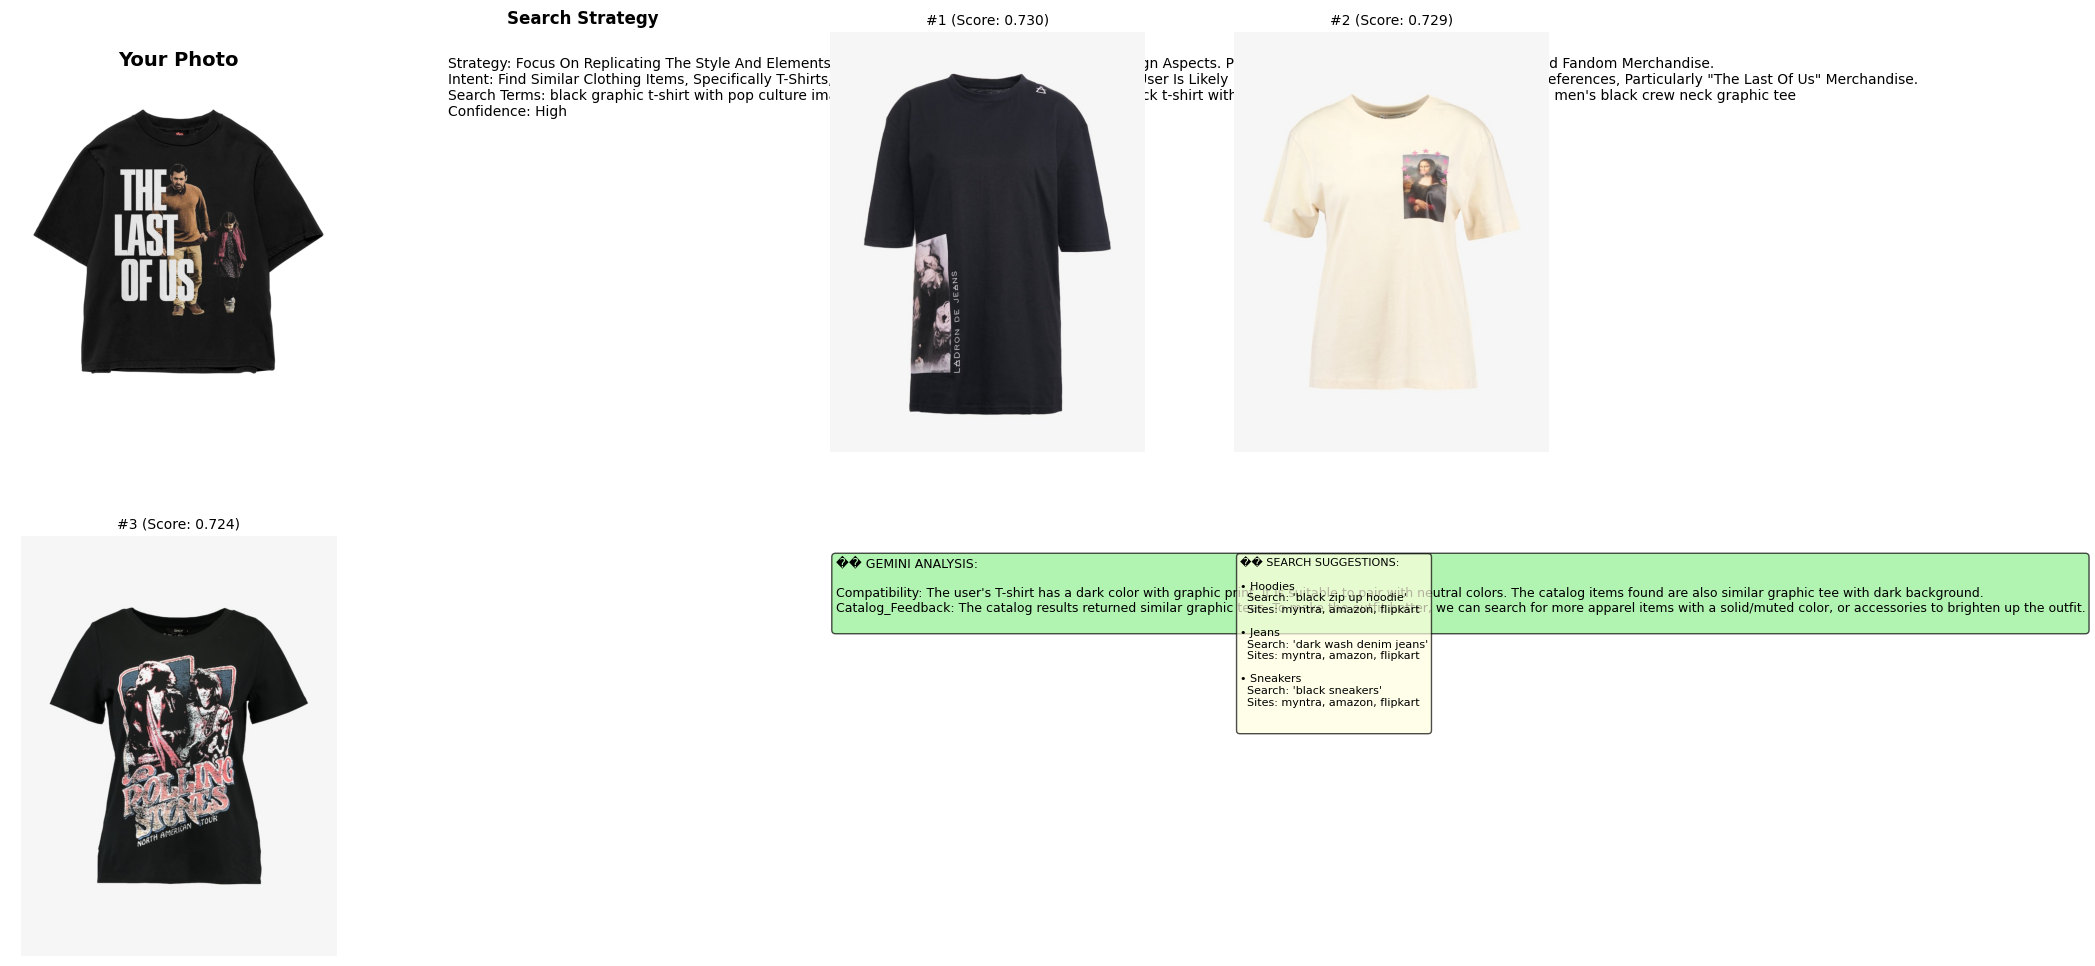


�� SEARCH STRATEGY: FOCUS ON REPLICATING THE STYLE AND ELEMENTS OF THE T-SHIRT, PARTICULARLY THE GRAPHIC DESIGN ASPECTS. PRIORITIZE SEARCHES FOR SIMILAR GRAPHIC TEES AND FANDOM MERCHANDISE.
User Intent: Find similar clothing items, specifically t-shirts, that resemble the one in the image. The user is likely interested in graphic tees with pop culture references, particularly "The Last of Us" merchandise.
Style Analysis: The image shows a black, possibly oversized, t-shirt with a graphic print featuring characters and the title of 'The Last of Us'. The style leans towards vintage or retro, possibly due to the aged or worn look of the print.
CLIP Search Terms: ['black graphic t-shirt with pop culture image', 'vintage style black t-shirt', 'oversized black t-shirt with movie character print', 'The Last of Us t-shirt', "men's black crew neck graphic tee"]
Detected Gender: unisex
Skin Tone: unknown
Body Type: unknown
Age Group: adult
Season: all-season
Occasion: casual
Color Palette: ['bl


Press Enter to continue to next scenario... 



==================== Complementary Items ====================
Prompt: What goes well with this outfit? I need something to pair with this
🧠 INTELLIGENT FASHION RECOMMENDATION SYSTEM
🎯 LLM-Guided CLIP Search...
🤖 LLM Strategy: Focus on complementary apparel items that match the style and theme of the graphic tee.
🔎 CLIP Search Terms: ['black graphic tee outfit ideas', 'casual outfit ideas with dark tee', 'streetwear style with black tee', "outfit ideas with 'The Last of Us' t-shirt", 'black cotton t-shirt matching clothes']
🎯 Enhancing recommendations...


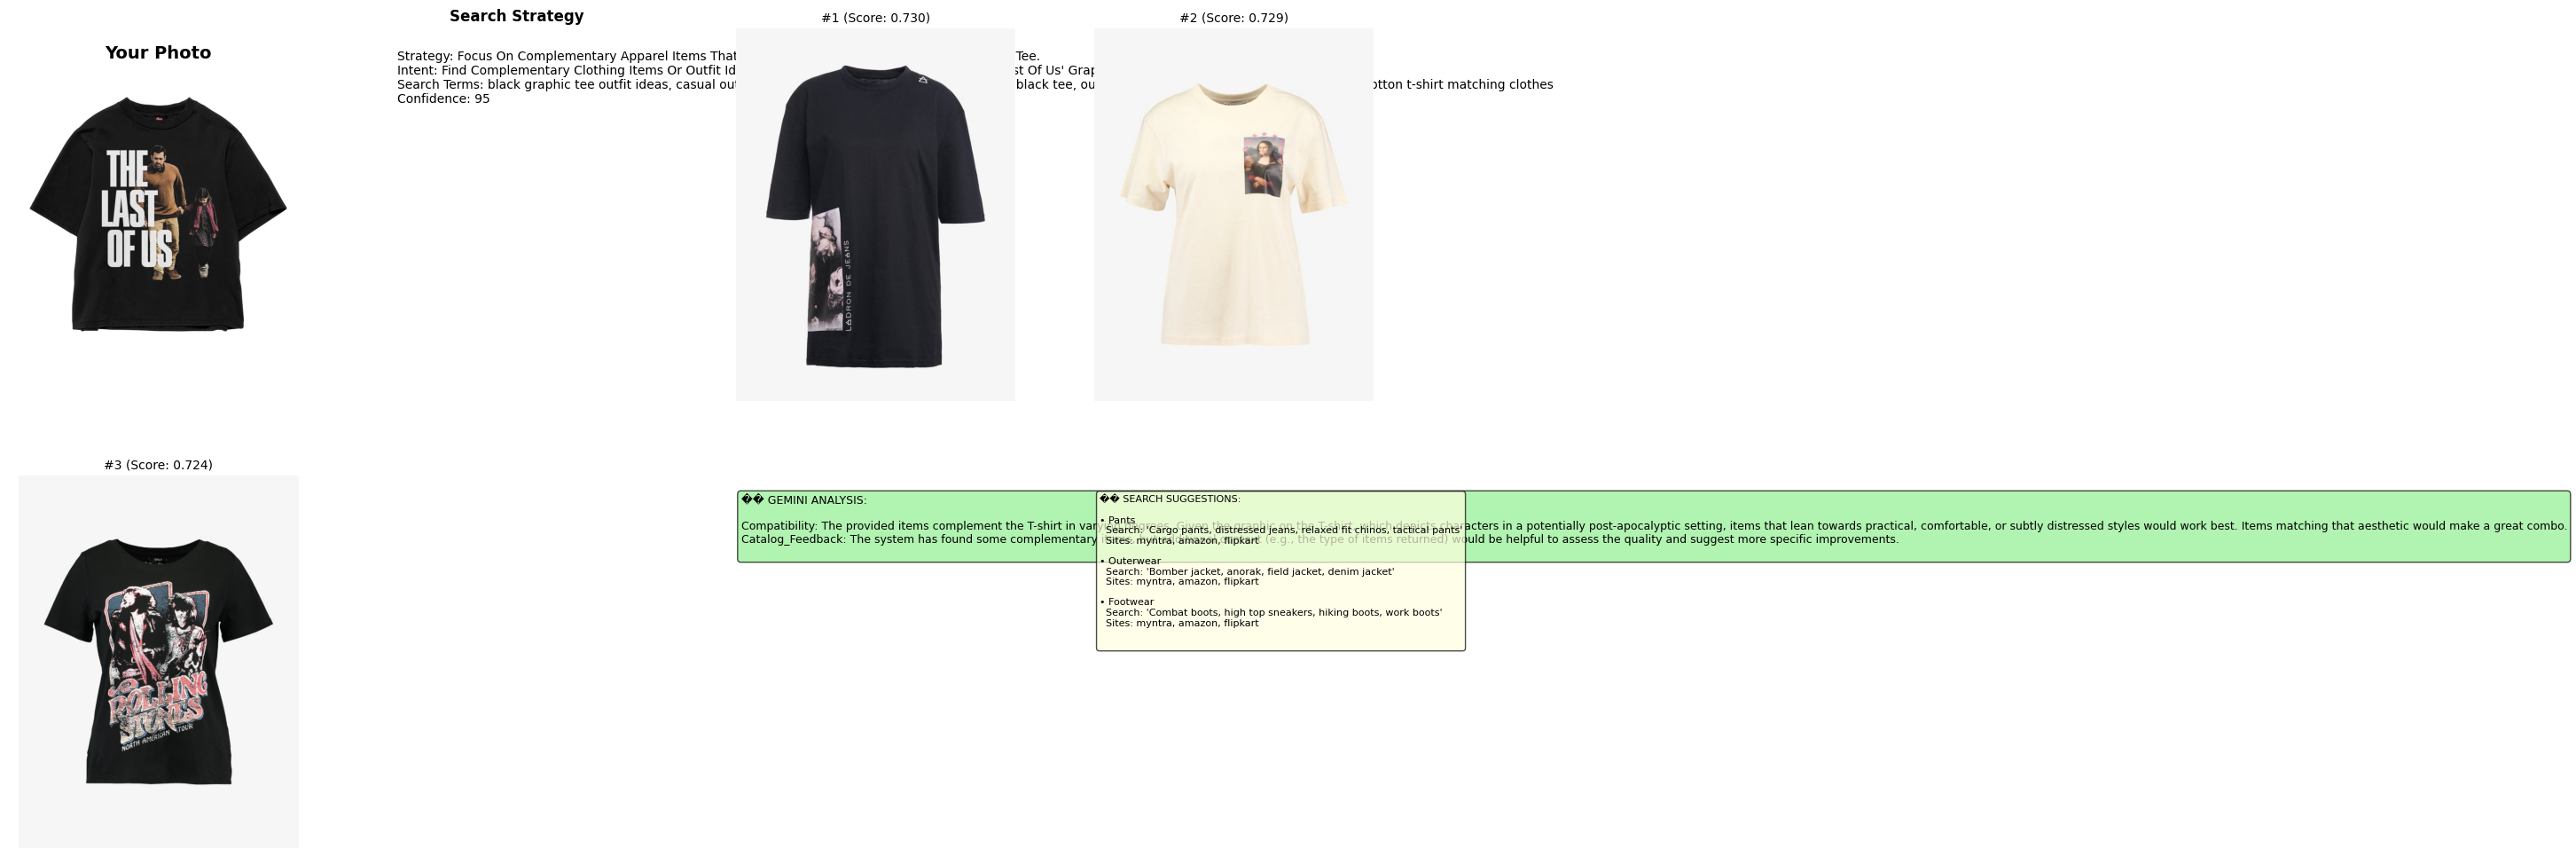


�� SEARCH STRATEGY: FOCUS ON COMPLEMENTARY APPAREL ITEMS THAT MATCH THE STYLE AND THEME OF THE GRAPHIC TEE.
User Intent: Find complementary clothing items or outfit ideas that pair well with the depicted 'The Last of Us' graphic t-shirt.
Style Analysis: The style is casual, likely streetwear. The t-shirt features a graphic from 'The Last of Us'. The user wants to create a full outfit.
CLIP Search Terms: ['black graphic tee outfit ideas', 'casual outfit ideas with dark tee', 'streetwear style with black tee', "outfit ideas with 'The Last of Us' t-shirt", 'black cotton t-shirt matching clothes']
Detected Gender: unisex
Skin Tone: unknown
Body Type: unknown
Age Group: adult
Season: all-season
Occasion: casual
Color Palette: ['black', 'white', 'brown']
Fashion Era: modern
Patterns: []
Materials: ['cotton']
Brands: []

�� CATALOG RESULTS: 5 items
#1: 12034_00.jpg (Score: 0.730)
#2: 08300_00.jpg (Score: 0.729)
#3: 11689_00.jpg (Score: 0.724)
#4: 03116_00.jpg (Score: 0.723)
#5: 05996_00.jpg 


Press Enter to continue to next scenario... 



==================== Outfit Evaluation ====================
Prompt: How do I look? Rate my outfit
🧠 INTELLIGENT FASHION RECOMMENDATION SYSTEM
🎯 LLM-Guided CLIP Search...
🤖 LLM Strategy: The primary subject is a t-shirt with a graphic print from 'The Last of Us' video game. The search strategy should focus on finding similar t-shirts and graphic tees.
🔎 CLIP Search Terms: ["black 'The Last of Us' graphic t-shirt", 'video game graphic tee', 'casual t-shirt with print for adults', 'dark color graphic tee for unisex', 'printed tee for casual wear']
🎯 Enhancing recommendations...


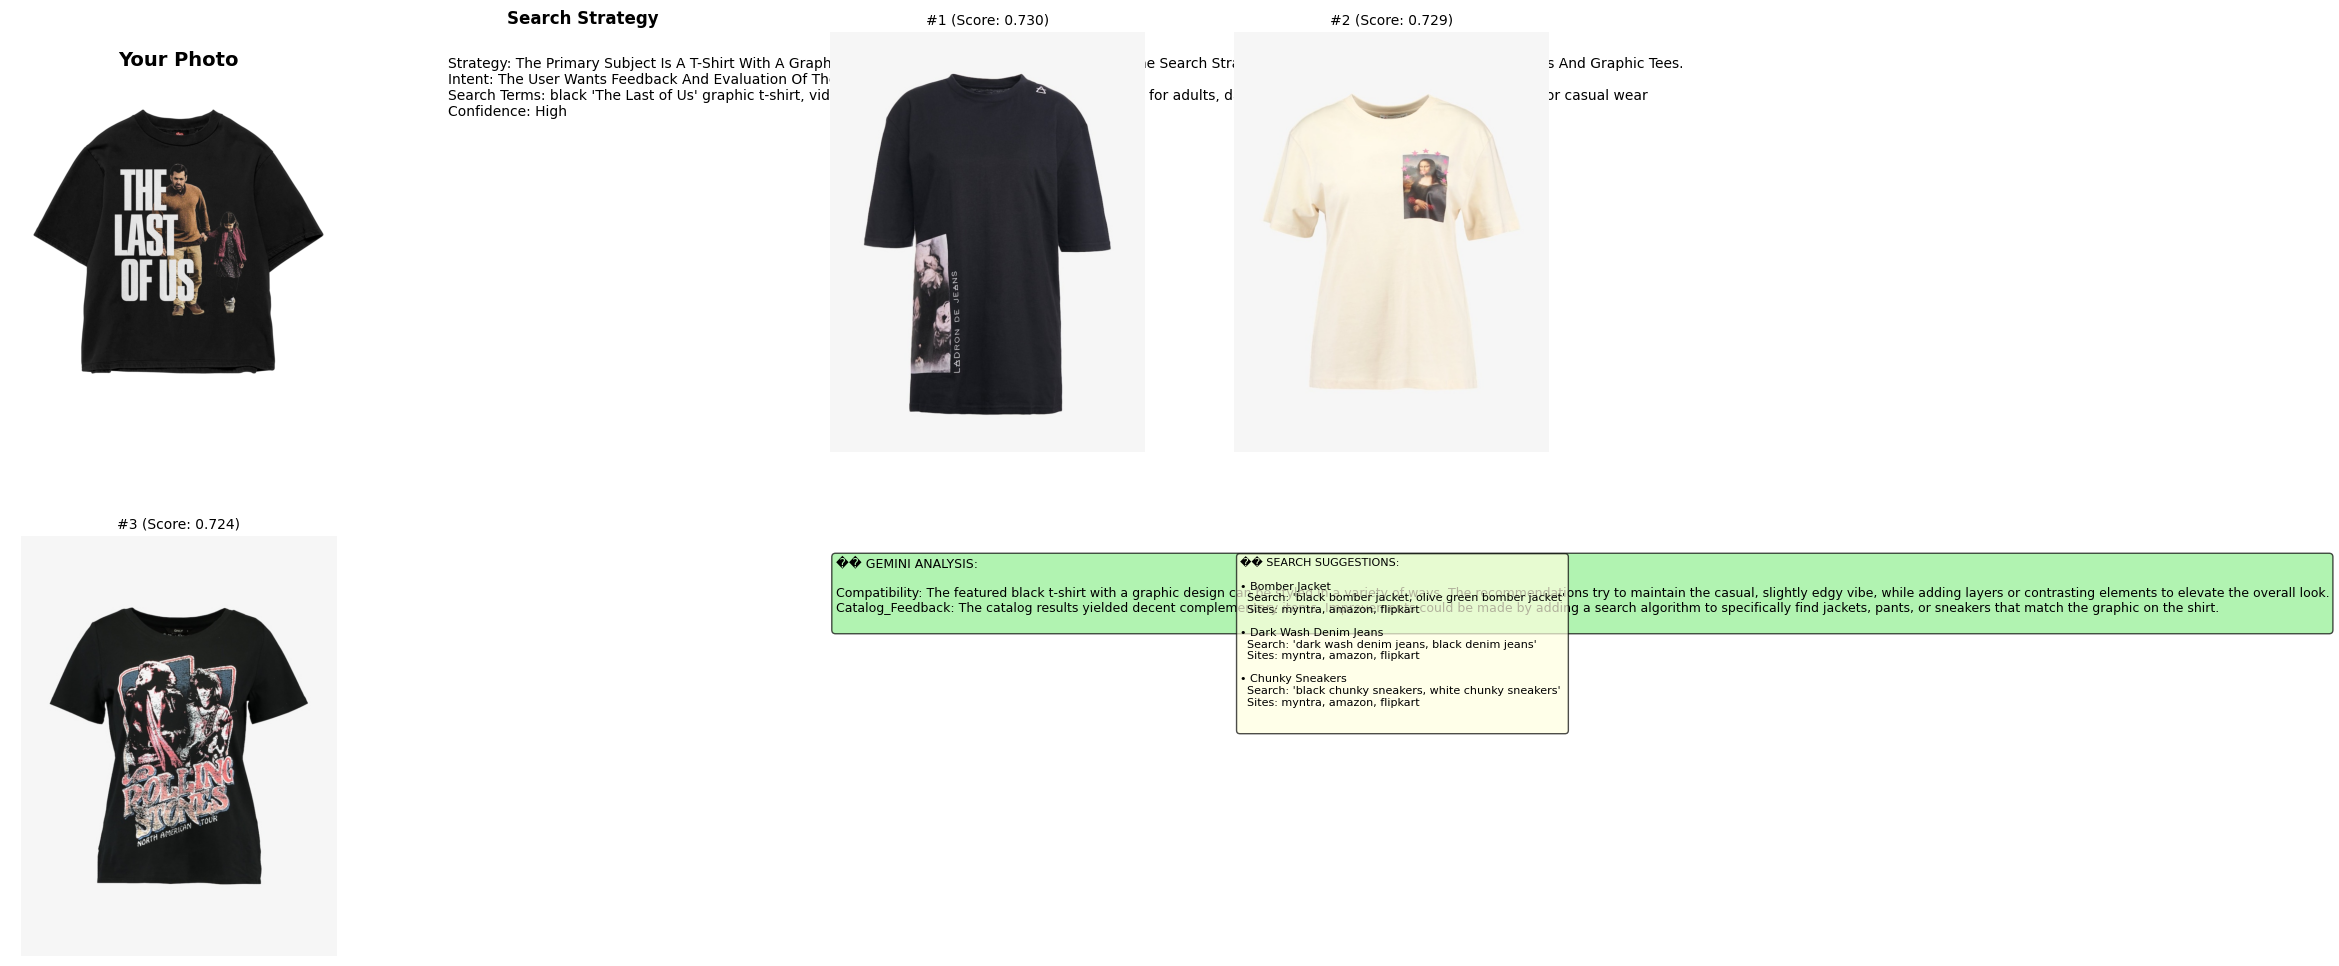


�� SEARCH STRATEGY: THE PRIMARY SUBJECT IS A T-SHIRT WITH A GRAPHIC PRINT FROM 'THE LAST OF US' VIDEO GAME. THE SEARCH STRATEGY SHOULD FOCUS ON FINDING SIMILAR T-SHIRTS AND GRAPHIC TEES.
User Intent: The user wants feedback and evaluation of their outfit (the t-shirt).
Style Analysis: The t-shirt is casual and features a graphic from a popular video game/tv show. It is suitable for everyday wear or for fans of the franchise. The color scheme is simple (black and white) with the graphic adding visual interest.
CLIP Search Terms: ["black 'The Last of Us' graphic t-shirt", 'video game graphic tee', 'casual t-shirt with print for adults', 'dark color graphic tee for unisex', 'printed tee for casual wear']
Detected Gender: unisex
Skin Tone: unknown
Body Type: unknown
Age Group: adult
Season: all-season
Occasion: casual
Color Palette: ['black', 'white', 'brown']
Fashion Era: modern
Patterns: []
Materials: ['cotton']
Brands: []

�� CATALOG RESULTS: 5 items
#1: 12034_00.jpg (Score: 0.730)
#2:


Press Enter to continue to next scenario... 


In [64]:
def test_different_scenarios():
    """Test the system with different user intents"""
    
    print("🧪 TESTING DIFFERENT SCENARIOS")
    print("="*60)
    
    user_images = [f for f in os.listdir(USER_IMAGES_PATH) if f.endswith(('.jpg', '.jpeg', '.png'))]
    if not user_images:
        print("❌ No user images found!")
        return
    
    demo_user_image = '/kaggle/input/testing-image/lastofuss.jpg'
    
    # Test scenarios
    scenarios = [
        {
            "name": "Similar Items",
            "prompt": "Show me clothes similar to this"
        },
        {
            "name": "Complementary Items", 
            "prompt": "What goes well with this outfit? I need something to pair with this"
        },
        {
            "name": "Outfit Evaluation",
            "prompt": "How do I look? Rate my outfit"
        }
    ]
    
    for scenario in scenarios:
        print(f"\n{'='*20} {scenario['name']} {'='*20}")
        print(f"Prompt: {scenario['prompt']}")
        
        catalog_recommendations, llm_analysis, gemini_analysis = get_intelligent_recommendations(
            demo_user_image, scenario['prompt'], top_k=5
        )
        
        display_intelligent_results(catalog_recommendations, llm_analysis, gemini_analysis, demo_user_image)
        
        input("\nPress Enter to continue to next scenario...")

# Run the test
test_different_scenarios()

In [57]:
def custom_fashion_recommendation():
    """Interactive interface for custom images and prompts"""
    
    print("�� CUSTOM FASHION RECOMMENDATION SYSTEM")
    print("="*60)
    print("Upload your image and get personalized recommendations!")
    print()
    
    # Option 1: Upload from file
    print("📁 Choose your image source:")
    print("1. Upload from file")
    print("2. Use URL")
    print("3. Use dataset image")
    
    choice = input("\nEnter your choice (1-3): ").strip()
    
    if choice == "1":
        # File upload
        from google.colab import files
        print("\n�� Please upload your image...")
        uploaded = files.upload()
        
        if uploaded:
            # Get the first uploaded file
            filename = list(uploaded.keys())[0]
            image_path = filename
            
            # Save to temporary location
            with open(image_path, 'wb') as f:
                f.write(uploaded[filename])
            
            print(f"✅ Uploaded: {filename}")
        else:
            print("❌ No file uploaded")
            return
    
    elif choice == "2":
        # URL input
        image_url = input("\n�� Enter image URL: ").strip()
        
        try:
            response = requests.get(image_url)
            if response.status_code == 200:
                # Save image
                image_path = "custom_image.jpg"
                with open(image_path, 'wb') as f:
                    f.write(response.content)
                print(f"✅ Downloaded image from URL")
            else:
                print("❌ Failed to download image")
                return
        except Exception as e:
            print(f"❌ Error downloading image: {e}")
            return
    
    elif choice == "3":
        # Use dataset image
        user_images = [f for f in os.listdir(USER_IMAGES_PATH) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        if not user_images:
            print("❌ No dataset images available")
            return
        
        print(f"\n📂 Available dataset images ({len(user_images)}):")
        for i, img in enumerate(user_images[:10]):
            print(f"  {i+1}. {img}")
        if len(user_images) > 10:
            print(f"  ... and {len(user_images) - 10} more")
        
        try:
            selection = int(input(f"\nSelect image (1-{min(10, len(user_images))}): ")) - 1
            if 0 <= selection < len(user_images):
                image_path = os.path.join(USER_IMAGES_PATH, user_images[selection])
                print(f"✅ Selected: {user_images[selection]}")
            else:
                print("❌ Invalid selection")
                return
        except:
            print("❌ Invalid input")
            return
    
    else:
        print("❌ Invalid choice")
        return
    
    # Get user prompt
    print("\n💬 What would you like to know about your outfit?")
    print("Examples:")
    print("• 'Show me clothes similar to this'")
    print("• 'What goes well with this outfit?'")
    print("• 'How do I look? Rate my outfit'")
    print("• 'I need something for a party'")
    print("• 'What jacket would go with this?'")
    
    user_prompt = input("\nEnter your request: ").strip()
    
    if not user_prompt:
        user_prompt = "Show me similar clothes"
        print(f"Using default prompt: {user_prompt}")
    
    # Display the image
    print(f"\n📸 Your Image:")
    try:
        img = Image.open(image_path)
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.title("Your Image", fontsize=14, fontweight='bold')
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"❌ Error displaying image: {e}")
        return
    
    # Get recommendations
    print(f"\n🔍 Processing your request: '{user_prompt}'")
    print("="*60)
    
    try:
        catalog_recommendations, llm_analysis, gemini_analysis = get_intelligent_recommendations(
            image_path, user_prompt, top_k=5
        )
        
        # Display results
        display_intelligent_results(catalog_recommendations, llm_analysis, gemini_analysis, image_path)
        
        # Interactive follow-up
        print("\n" + "="*60)
        print("💬 Would you like to ask a follow-up question?")
        print("Examples:")
        print("• 'What accessories would go with this?'")
        print("• 'Show me more options'")
        print("• 'What about shoes?'")
        print("• 'No, thanks'")
        
        follow_up = input("\nEnter follow-up question (or 'no' to end): ").strip()
        
        if follow_up.lower() not in ['no', 'n', '']:
            print(f"\n🔍 Processing follow-up: '{follow_up}'")
            print("="*60)
            
            # Combine original prompt with follow-up
            combined_prompt = f"{user_prompt}. Also, {follow_up}"
            
            catalog_recommendations2, llm_analysis2, gemini_analysis2 = get_intelligent_recommendations(
                image_path, combined_prompt, top_k=3
            )
            
            display_intelligent_results(catalog_recommendations2, llm_analysis2, gemini_analysis2, image_path)
        
        print("\n✅ Thank you for using the Fashion Recommendation System!")
        
    except Exception as e:
        print(f"❌ Error processing request: {e}")
        print("Please try again with a different image or prompt.")

# Run the custom interface
custom_fashion_recommendation()

�� CUSTOM FASHION RECOMMENDATION SYSTEM
Upload your image and get personalized recommendations!

📁 Choose your image source:
1. Upload from file
2. Use URL
3. Use dataset image



Enter your choice (1-3):  


❌ Invalid choice


📂 Found 11647 catalog images. Running similarity checks...


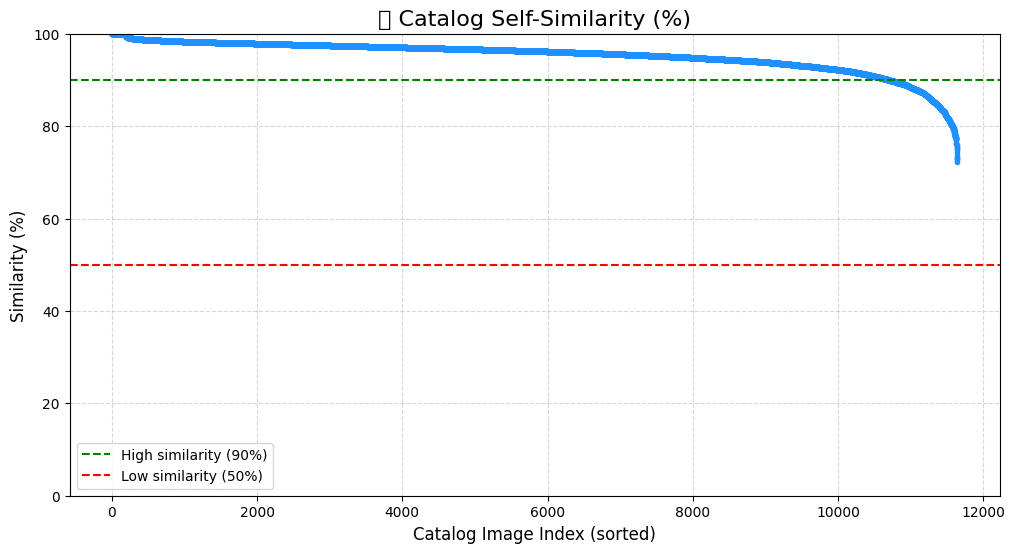

✅ Mean similarity: 95.21%
✅ Median similarity: 96.23%
🔼 Items above 90% similarity: 10700
🔽 Items below 50% similarity: 0


In [94]:
import os 
import matplotlib.pyplot as plt
import numpy as np

# Directory with catalog images
catalog_dir = "/kaggle/input/clothes-tryon-dataset/clothes_tryon_dataset/train/cloth"
catalog_images = [os.path.join(catalog_dir, f) for f in os.listdir(catalog_dir) if f.endswith(('.jpg', '.png'))]

similarity_percentages = []

print(f"📂 Found {len(catalog_images)} catalog images. Running similarity checks...")

for img_path in catalog_images:
    # Use each catalog image as a query
    recommendations = search_similar_items(img_path, top_k=2)  # top_k=2 to skip the image itself
    
    if recommendations and len(recommendations) > 1:
        # Skip the first result if it's the same image (cosine similarity=1)
        retrieved_img = recommendations[1]['image_path']
        similarity_score = recommendations[1]['similarity_score']
        similarity_percentages.append(similarity_score * 100)  # Convert to %
    else:
        similarity_percentages.append(0)  # Fallback if no results

# Sort for visualization
sorted_percentages = sorted(similarity_percentages, reverse=True)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(sorted_percentages, color='dodgerblue', linewidth=2, marker='o', markersize=3)
plt.title('🟦 Catalog Self-Similarity (%)', fontsize=16)
plt.xlabel('Catalog Image Index (sorted)', fontsize=12)
plt.ylabel('Similarity (%)', fontsize=12)
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.5)

# Highlight zones
plt.axhline(90, color='green', linestyle='--', label='High similarity (90%)')
plt.axhline(50, color='red', linestyle='--', label='Low similarity (50%)')

# Legend
plt.legend()
plt.show()

# Summary stats
print(f"✅ Mean similarity: {np.mean(similarity_percentages):.2f}%")
print(f"✅ Median similarity: {np.median(similarity_percentages):.2f}%")
print(f"🔼 Items above 90% similarity: {sum(np.array(similarity_percentages) >= 90)}")
print(f"🔽 Items below 50% similarity: {sum(np.array(similarity_percentages) < 50)}")


Computing top-K similarities for each catalog image...


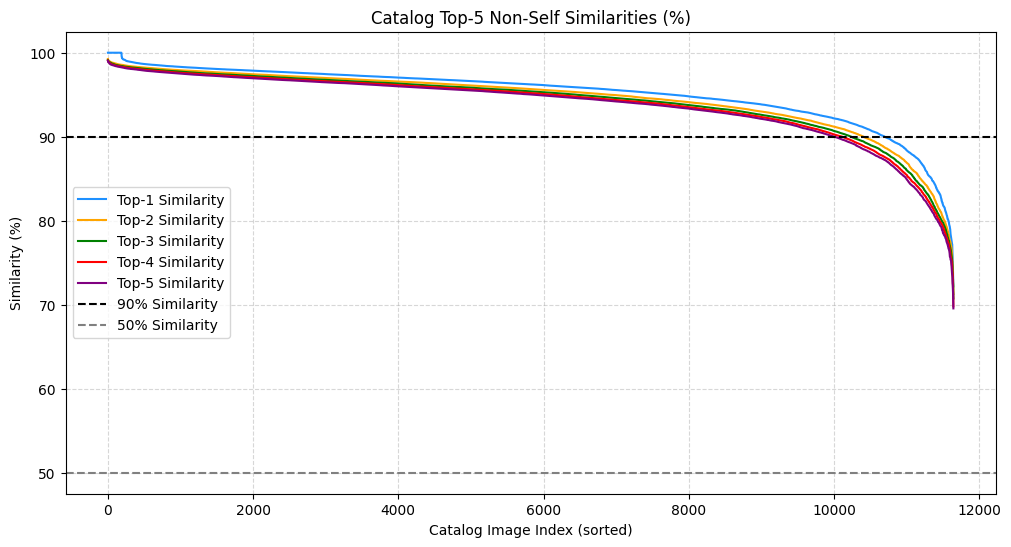

Top-1 mean: 95.21% | median: 96.23%
Top-2 mean: 94.51% | median: 95.68%
Top-3 mean: 94.18% | median: 95.41%
Top-4 mean: 93.93% | median: 95.19%
Top-5 mean: 93.74% | median: 95.03%


In [95]:
import numpy as np
import matplotlib.pyplot as plt

# Assume: catalog_index, catalog_files, extract_embedding, load_and_preprocess_image are defined

K = 5  # Top-K similarities to analyze (excluding self)
all_topk_similarities = [[] for _ in range(K)]

print("Computing top-K similarities for each catalog image...")
for i, filename in enumerate(catalog_files):
    image_path = os.path.join(CATALOG_PATH, filename)
    image_tensor = load_and_preprocess_image(image_path)
    if image_tensor is None:
        continue
    embedding = extract_embedding(image_tensor)
    # Search for top K+1 (to skip self-match)
    similarities, indices = catalog_index.search(embedding.reshape(1, -1), K+1)
    sim_scores = similarities[0]
    idxs = indices[0]
    # Remove self-match (should be at index 0)
    filtered = [(s, idx) for s, idx in zip(sim_scores, idxs) if idx != i]
    # Take top-K non-self
    for k in range(K):
        if k < len(filtered):
            all_topk_similarities[k].append(filtered[k][0] * 100)  # Convert to %
        else:
            all_topk_similarities[k].append(np.nan)

# Convert to numpy arrays for easier handling
all_topk_similarities = [np.array(lst) for lst in all_topk_similarities]

# Plot
plt.figure(figsize=(12, 6))
colors = ['dodgerblue', 'orange', 'green', 'red', 'purple']
for k in range(K):
    sorted_sim = np.sort(all_topk_similarities[k])[::-1]
    plt.plot(sorted_sim, color=colors[k], label=f'Top-{k+1} Similarity')
plt.axhline(90, color='black', linestyle='--', label='90% Similarity')
plt.axhline(50, color='grey', linestyle='--', label='50% Similarity')
plt.title(f'Catalog Top-{K} Non-Self Similarities (%)')
plt.xlabel('Catalog Image Index (sorted)')
plt.ylabel('Similarity (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Print summary stats for each K
for k in range(K):
    print(f"Top-{k+1} mean: {np.nanmean(all_topk_similarities[k]):.2f}% | median: {np.nanmedian(all_topk_similarities[k]):.2f}%")